In [83]:
import numpy as np
from Common_function import *
import matplotlib.pyplot as plt
from itertools import product
import itertools

x = 1  #how are is the distance set
Total_E_UGV = 500000
Total_E_UAV = 15000
UAV_E_cost = 1250

UGV_E_cost_with_UAV = 1000
UGV_E_cost_without_UAV = 800
Charging_speed = 1000
speed_uav =30
speed_ugv =10
ten_minets = 1
survey_time = ten_minets/6
UAV_E_s_cost = 2500*ten_minets
print(UAV_E_s_cost)
waypoints = [(20, 10), (24, 37), (36, 43), (8, 8), (0, 50), (30, 44), (28, 4), (32, 25)]
# # waypoints = [(20,10), (10,10),(15,30)]
# plan_output = "0 -> 1 -> 2 -> 0"
plan_output = "0 -> 3 -> 4 -> 1 -> 5 -> 2 -> 7 -> 6 -> 0"
# waypoints = [(20,10), (10,10), (10,30)]
# plan_output = "0 -> 1 -> 2 -> 0"
max_radius = ((Total_E_UAV - UAV_E_s_cost) / UAV_E_cost) / 2
radii = np.linspace(1.0, max_radius, x)
ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
ordered_points.append(ordered_points[0])


2500


In [84]:
radii

array([1.])

Idea to do:
1. 首先是dft,radius从大到小排列，然后设置当前最小值跳过，但是这个跳过很有可能只发生在树的最后一层，所有还是得花很多时间，

2. 至于没有的TSP的情况，只需要把plan output 遍历就行 就是大小是 (n-1)!,如果不优化，算到天荒地老，所有我把顺序换成了优先算TSP选的结果，如果后面的更慢，就可以在最后一层跳过了

3. MCTS ideas:
 Traverse the tree from the root using the UCB1 formula,expand it by adding child nodes for each possible radius from the next layer
 
MCTS Steps:
    Selection(done)
    Expansion(done)
    Simulation(working)
    Backpropagation(working)

Bug： (fixed)
不知道为什么radius combination的结果和实际的顺序结果差了一位：
Output是：
[5.0, 5.0, 1.0, 1.0, 5.0, 5.0, 3.0]
实际情况是：
[5.0, 1.0, 1.0, 5.0, 5.0, 3.0，5.0]
就好像是填list的时候是FIFO 然最后一个位置填错了一样,但是后面的计算都是正确的，我估计会直接写一个修改

In [85]:

def generate_combinations(plan_output):
    # Split the plan_output by '->' and remove spaces
    nodes = [node.strip() for node in plan_output.split('->')]
    
    # Exclude the starting and ending '0' for permutations
    internal_nodes = nodes[1:-1]
    
    # Generate all permutations of the internal nodes
    permutations = itertools.permutations(internal_nodes)
    
    # Construct the paths
    paths = ['0 -> ' + ' -> '.join(perm) + ' -> 0' for perm in permutations]
    
    return paths


In [86]:
# Define the plan_output string
# plan_output = "0 -> 3 -> 4 -> 1 -> 5 -> 2 -> 7 -> 6 -> 0"

# Test the function with the provided plan_output
plan_result = generate_combinations(plan_output)
plan_result[:10], len(plan_result)  # Displaying first 5 results and the total number of combinations


(['0 -> 3 -> 4 -> 1 -> 5 -> 2 -> 7 -> 6 -> 0',
  '0 -> 3 -> 4 -> 1 -> 5 -> 2 -> 6 -> 7 -> 0',
  '0 -> 3 -> 4 -> 1 -> 5 -> 7 -> 2 -> 6 -> 0',
  '0 -> 3 -> 4 -> 1 -> 5 -> 7 -> 6 -> 2 -> 0',
  '0 -> 3 -> 4 -> 1 -> 5 -> 6 -> 2 -> 7 -> 0',
  '0 -> 3 -> 4 -> 1 -> 5 -> 6 -> 7 -> 2 -> 0',
  '0 -> 3 -> 4 -> 1 -> 2 -> 5 -> 7 -> 6 -> 0',
  '0 -> 3 -> 4 -> 1 -> 2 -> 5 -> 6 -> 7 -> 0',
  '0 -> 3 -> 4 -> 1 -> 2 -> 7 -> 5 -> 6 -> 0',
  '0 -> 3 -> 4 -> 1 -> 2 -> 7 -> 6 -> 5 -> 0'],
 5040)

In [87]:

def calculate_energy_remaining_inter(Total_E_UGV, Total_E_UAV, UGV_outer_path_distances, UGVD_inter_with_drone, UAV_distances_set, UAV_path, UAV_E_cost, UAV_E_s_cost, UGVD_inter_without_drone, UGV_E_cost_without_UAV, Charging_speed):
    UGV_energy_remaining = Total_E_UGV
    UAV_energy_remaining = Total_E_UAV

    for i in range(len(UGV_outer_path_distances)-1):
        charging_distance = UGVD_inter_with_drone[i] + UGV_outer_path_distances[i+1]
        UAV_distances = UAV_distances_set[i]
        
        UAV_Trip_Cost = UAV_distances * UAV_E_cost + UAV_E_s_cost * (len(UAV_path[i])-2)
        UGV_Trip_Cost = UGVD_inter_without_drone[i] * UGV_E_cost_without_UAV
        
        UAV_energy_remaining -= UAV_Trip_Cost 
        UGV_energy_remaining -= UGV_Trip_Cost
        
        if UAV_energy_remaining < Total_E_UAV:
            charge_amount = min(Charging_speed * charging_distance , UAV_Trip_Cost, UGV_energy_remaining)
            UGV_energy_remaining -= charge_amount
            UAV_energy_remaining += charge_amount
        
        if UGV_energy_remaining < 0 or UAV_energy_remaining < 0:
            return -1, -1  # Indicating mission failed for both

    return UGV_energy_remaining, UAV_energy_remaining

In [88]:
def calculate_UAV_inter_distances_inter(UAV_path):
    UAV_inter_distances = 0
    group_distance=0
    for i in range(len(UAV_path) - 1):
        group_distance += compute_distance(UAV_path[i], UAV_path[i + 1])
    UAV_inter_distances=group_distance
    return UAV_inter_distances

In [89]:

def compute_optimized_paths_for_radius_updated_v4(ordered_points, radius_combination, speed_ugv, speed_uav, survey_time):
    UGV_outer_path = []
    UGV_path = [ordered_points[0]]
    UAV_path = []
    UGVD_inter_without_drone = []
    UGVD_inter_with_drone = []
    chord_end = None
    prev_chord_end = None
    final_wait_set = []
    radius_set = []
    for i, point in enumerate(ordered_points[:-1]):
        # radius_combination
        current_radius = radius_combination[i % len(radius_combination)]
        print(radius_combination,i % len(radius_combination) )
        # print(i, point)
        
        # print(current_radius)
        # Exclude the start and end points from circles
        if 0 < i < len(ordered_points) - 2:
            angle = angle_between_points(ordered_points[i-1], ordered_points[i])
            nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
            chord_start = point_on_circle(ordered_points[i], angle - np.pi, current_radius)
            chord_end = point_on_circle(ordered_points[i], nextangle, current_radius)
            radius_set.append(current_radius)
            if prev_chord_end and i > 1 and circles_overlap(ordered_points[i], current_radius, ordered_points[i-1], radius_combination[(i-1) % len(radius_combination)]):
                chord_start = prev_chord_end

            final_meeting_point, final_wait_time = find_meeting_point_with_survey_final(
                ordered_points[i], current_radius, chord_start, chord_end, 
                speed_ugv, speed_uav, survey_time
            )
            final_wait_set.append(final_wait_time)
            # Update paths based on the provided structure
            if chord_start:
                UAV_path_segment = [chord_start, point, final_meeting_point]
                UAV_path.append(UAV_path_segment)
                UGV_path.append(chord_start)
                UAV_path_segment_distance = calculate_UAV_inter_distances_inter(UAV_path_segment)
                # Update UGV_outer_path as per the new structure
                if i == 1:
                    UGV_outer_path.append([ordered_points[0], chord_start])
                else:
                    UGV_outer_path.append([prev_chord_end, chord_start])
                
                    
                
            if chord_end:
                UGV_path.append(chord_end)
            inter_distance_without_drone = compute_distance(chord_start, final_meeting_point)
            inter_distance_with_drone = compute_distance(final_meeting_point, chord_end)
            UGVD_inter_without_drone.append(inter_distance_without_drone)
            UGVD_inter_with_drone.append(inter_distance_with_drone)
            prev_chord_end = chord_end

            
            # print(UAV_path_segment_distance)
            # print ( UGV_outer_path_distances, inter_distance_with_drone, UAV_distances_set, UAV_path_segment, UAV_E_cost, UAV_E_s_cost, UGVD_inter_without_drone, UGV_E_cost_without_UAV, Charging_speed)
            # UGV_energy_remaining, UAV_energy_remaining = calculate_energy_remaining_inter(Total_E_UGV, Total_E_UAV, UGV_outer_path_distances, UGVD_inter_with_drone, UAV_distances_set, UAV_path, UAV_E_cost, UAV_E_s_cost, UGVD_inter_without_drone, UGV_E_cost_without_UAV, Charging_speed)

    # Adding the last point to the paths
    UGV_path.append(ordered_points[-1])
    UGV_outer_path.append([chord_end,ordered_points[-1]])
    
    return radius_set ,UGV_path, UAV_path, UGV_outer_path, UGVD_inter_without_drone, UGVD_inter_with_drone,final_wait_set

In [99]:
def calculate_total_wait_time(final_wait_time):
    return sum(final_wait_time)
def calculate_UGV_total_distance(UGV_path):
    UGV_total_distance = 0
    for i in range(len(UGV_path) - 1):
        print(compute_distance(UGV_path[i], UGV_path[i + 1]))
        UGV_total_distance += compute_distance(UGV_path[i], UGV_path[i + 1])
    return UGV_total_distance

def calculate_UGV_outer_path_distances(UGV_outer_path):
    UGV_outer_path_distances = []
    for group in UGV_outer_path:
        UGV_outer_path_distances.append(compute_distance(group[0], group[1]))
    return UGV_outer_path_distances

def calculate_UAV_inter_distances(UAV_path):
    UAV_inter_distances = []
    for group in UAV_path:
        group_distance = 0
        for i in range(len(group) - 1):
            group_distance += compute_distance(group[i], group[i + 1])
        UAV_inter_distances.append(group_distance)
    return format_list_to_decimal(UAV_inter_distances)

UGVdistances = []
UAV_total_distances = []
UAV_distances_set = []
ordered_points = compute_ordered_points(plan_output, waypoints)
result = []
for radius_combination in product(radii, repeat=len(waypoints) - 1):
    radius_set, UGV_path, UAV_path, UGV_outer_path, UGVD_inter_without_drone,UGVD_inter_with_drone,final_wait_time= compute_optimized_paths_for_radius_updated_v4(ordered_points, radius_combination, speed_ugv, speed_uav, survey_time)
    # print(final_wait_time)
    total_wait_time = calculate_total_wait_time(final_wait_time)
    UGV_total_distance = calculate_UGV_total_distance(UGV_path)
    UGV_outer_path_distances = calculate_UGV_outer_path_distances(UGV_outer_path)
    
    UGV_outer_path_E_cost = [distance * UGV_E_cost_with_UAV for distance in UGV_outer_path_distances]
    total_time = total_wait_time + UGV_total_distance / speed_ugv
    # print(total_time)
    
    UAV_inter_distances = calculate_UAV_inter_distances(UAV_path)
    UAV_inter_distances = [float(distance) for distance in UAV_inter_distances]
    UAV_inter_E_cost = [(distance * UAV_E_cost) + UAV_E_s_cost for distance in UAV_inter_distances]
    UAV_distances_set = calculate_UAV_distances(UAV_path, compute_distance)

    UGV_energy_remaining, UAV_energy_remaining = calculate_energy_remaining(Total_E_UGV, Total_E_UAV, UGV_outer_path_distances, UGVD_inter_with_drone, UAV_distances_set, UAV_path, UAV_E_cost, UAV_E_s_cost, UGVD_inter_without_drone, UGV_E_cost_without_UAV, Charging_speed)
    
    # print(f"radius_combination:{radius_combination}")
    if UGV_energy_remaining == -1 or UAV_energy_remaining == -1:
        
        result.append((radius_set,None))
    else:
        result.append((radius_set,round(total_time,2)))
        # print(radius_set)
        # print(f"UGV_energy_remaining:{UGV_energy_remaining:.2f}, UAV_energy_remaining:{UAV_energy_remaining:.2f}")
        # print(f"total_time:{total_time:.2f} \n")


(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0) 0
(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0) 1
(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0) 2
(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0) 3
(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0) 4
(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0) 5
(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0) 6
(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0) 0
(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0) 1
11.16552506059644
1.4304340465657719
40.7551166528639
0.8574409849568205
25.294688127912366
1.5560298849613203
7.2195444572928835
1.741904497913468
4.082762530298219
1.3758672018973253
16.439088914585774
1.9997682428167836
19.377558326431952
1.05857125075123
9.0


In [91]:
novaild_plan = sum(1 for _, value in result if value is None)
vaild_plan =  sum(1 for _, value in result if value is not None)
vaild_plan

1

In [92]:
novaild_plan

0

In [93]:
novaild_plan+vaild_plan*5050


5050

In [94]:
max_time = max(result, key=lambda x: float('-1') if x[1] is None else x[1])
min_time = min(result, key=lambda x: float('inf') if x[1] is None else x[1])
print(f"min_time:{min_time}, max_time:{max_time}")
# min_time = ([5.0,5.0, 5.0, 3.0, 1.0, 5.0, 1.0], 13.03)

min_time:([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 14.97), max_time:([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 14.97)


In [95]:
UGV_path, UAV_path, UGV_outer_path, UGVD_inter_without_drone,UGVD_inter_with_drone,final_wait_time= compute_optimized_paths_for_radius_updated_v3(ordered_points, min_time[0], speed_ugv, speed_uav, survey_time)

radius_combination = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
radius_combination = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
i = 1,point =(8, 8),current_radius = 1.0
radius_combination = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
i = 2,point =(0, 50),current_radius = 1.0
radius_combination = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
i = 3,point =(24, 37),current_radius = 1.0
radius_combination = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
i = 4,point =(30, 44),current_radius = 1.0
radius_combination = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
i = 5,point =(36, 43),current_radius = 1.0
radius_combination = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
i = 6,point =(32, 25),current_radius = 1.0
radius_combination = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
i = 7,point =(28, 4),current_radius = 1.0
radius_combination = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


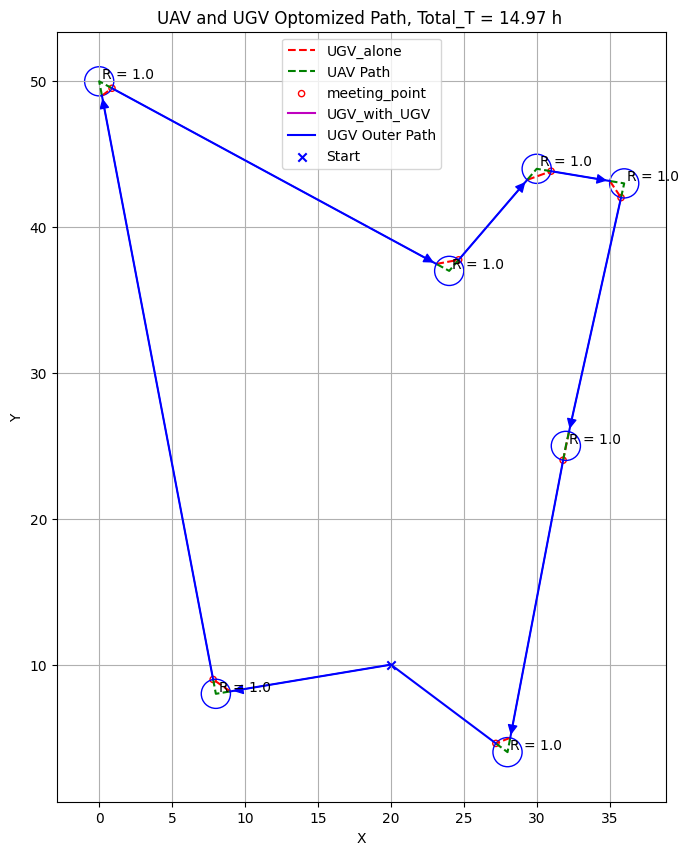

In [96]:
from matplotlib.patches import FancyArrowPatch
def plot_updated_paths_with_circles(UAV_path, UGV_outer_path, ordered_points, result):
    fig, ax = plt.subplots(figsize=(10, 10))
    time= result[1]
    radius_combination = result[0]
    # # Plot UAV_path
    # for segment in UAV_path:
    #     # print(segment[0],segment[-1])
    #     ax.plot(*zip(segment[0],segment[-1]),'r--',label='UGV_alone')
        
    #     ax.plot(*zip(*segment), 'g--', label='UAV Path')
    #     # ax.scatter(*zip(*segment), color='g', marker='o')
    
    # # Plot UGV_outer_path without connecting segments to each other
    # for segment in UGV_outer_path:
    #     ax.plot(*zip(*segment), 'b-', label='UGV Outer Path')

        # ax.scatter(segment[0][0], segment[0][1], color='b', marker='x')  # Plotting start of the segment
        # ax.scatter(segment[1][0], segment[1][1], color='b', marker='x')  # Plotting end of the segment
    for index, segment in enumerate(UAV_path):
    # Plot for UAV_path
        ax.plot(*zip(segment[0], segment[-1]), 'r--', label='UGV_alone')
        ax.plot(*zip(*segment), 'g--', label='UAV Path')
        ax.scatter(*segment[-1], s=20, marker='o', facecolors='none', edgecolors='r', label='meeting_point')  # Plotting end of the segment
        ax.plot(*zip(segment[-1],UGV_outer_path[index+1][0]), 'm-', label='UGV_with_UGV')
        # Plot for UGV_outer_path
        # ax.plot(*zip(*UGV_outer_path[index]), 'b-', label='UGV Outer Path')
        line = ax.plot(*zip(*UGV_outer_path[index]), 'b-', label='UGV Outer Path')
        start_point = UGV_outer_path[index][0]
        end_point = UGV_outer_path[index][-1]
        arrow = FancyArrowPatch(posA=start_point, posB=end_point, mutation_scale=15, arrowstyle="-|>", color="b")
        ax.add_patch(arrow)
    # Since UGV_outer_path has one more segment, plot the last segment of UGV_outer_path separately
    ax.plot(*zip(*UGV_outer_path[-1]), 'b-', label='UGV Outer Path')
    # Draw circles
    for i, point in enumerate(ordered_points[:-1]):
        
        if 0 < i < len(ordered_points) - 2:
            
            current_radius = radius_combination[i-1]
            ax.annotate(f"R = {current_radius:.1f}", (point[0] + 0.2, point[1] + 0.2))
            draw_circle(ax, point, current_radius, color='b', linestyle='-')
        
    ax.scatter(*ordered_points[0], color='b', marker='x',label='Start')  # Plotting start of the segment 
    # Labels and Title
    ax.set_title(f"UAV and UGV Optomized Path, Total_T = {min_time[1]} h ")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)
    
    # Handling legends to avoid repetition
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = list(dict.fromkeys(labels))
    unique_handles = [handles[labels.index(lab)] for lab in unique_labels]
    ax.legend(unique_handles, unique_labels, loc="best")
    ax.set_aspect('equal', adjustable='box')
    plt.show()

# Given ordered points


# Plotting the updated paths with circles
plot_updated_paths_with_circles(UAV_path, UGV_outer_path, ordered_points, min_time)


In [97]:
min_time[0]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]